In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
aisles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/aisles.csv')
departments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/departments.csv')

order_products_prior = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/order_products__prior.csv')

orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/orders.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/products.csv')

In [ ]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')


In [ ]:
order_products = order_products.merge(aisles, on ='aisle_id', how='left')


In [ ]:
order_products = order_products.merge(departments, on ='department_id', how='left')


In [ ]:
del aisles, departments, order_products_prior

In [ ]:
order_products = order_products.merge(orders, on='order_id', how='left')


In [ ]:
del orders, products

In [ ]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [ ]:
order_products.user_id.nunique()

206209

## Segmentation

Поскольку в наборе данных есть тысячи продуктов, я буду полагаться на проходы, которые представляют категории продуктов. Даже при наличии проходов функций будет слишком много, поэтому я воспользуюсь анализом главных компонентов, чтобы найти новые измерения, по которым будет проще кластеризовать.

In [ ]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [ ]:
del order_products

Нормализую

In [ ]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016667,0.016667
2,0.0,0.015306,0.0,0.0,0.0,0.0,0.010204,0.0,0.0,0.0,...,0.005102,0.005102,0.000000,0.0,0.0,0.0,0.010204,0.0,0.214286,0.005102
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.011111,0.000000,0.000000,0.0,0.0,0.0,0.022222,0.0,0.000000,0.022222
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.052632,0.0,0.0,0.0,0.052632,0.0,0.000000,0.052632
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081,0.000000


In [ ]:
df.shape

(206209, 135)

### PCA and K-Means Clustering

Надо уменьшить фрейм данных до 10 измерений, поскольку KMeans не работает должным образом в более высоком измерении.

In [ ]:
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score

In [ ]:
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2
0,-0.116044,0.020748,-0.027239
1,-0.048154,0.099395,-0.099567
2,0.047407,0.110385,-0.004425
3,-0.102760,0.041186,0.012228
4,0.101737,-0.023372,-0.038860


In [ ]:
del df

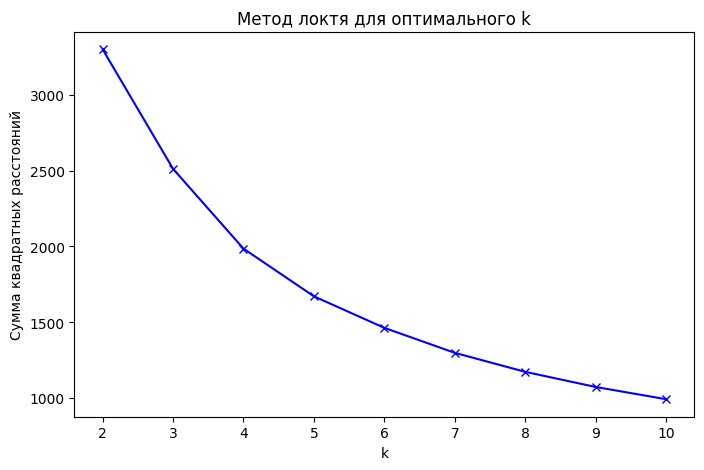

In [ ]:
Sum_of_squared_distances = []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Сумма квадратных расстояний')
plt.title('Метод локтя для оптимального k')
plt.show()

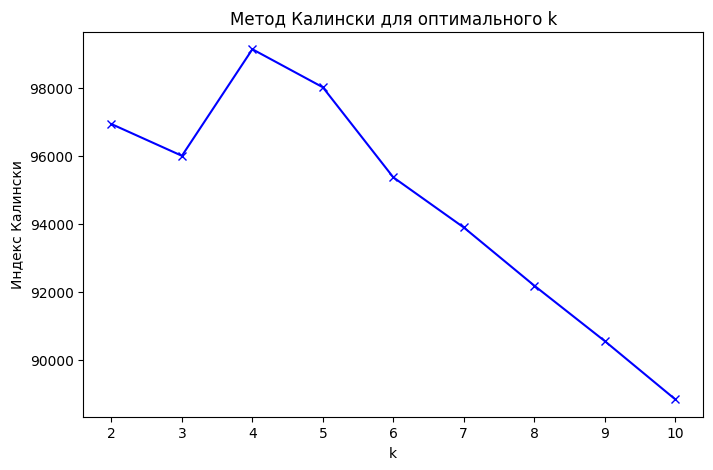

In [ ]:
calinski_harabasz_score_results = []
for k in range(2,11):
    km = KMeans(n_clusters=k)
    km = km.fit_predict(df_pca)

    db_index = calinski_harabasz_score(df_pca, km)
    calinski_harabasz_score_results.append(db_index)


plt.subplots(figsize = (8, 5))
plt.plot(range(2,11), calinski_harabasz_score_results, 'bx-')
plt.xlabel("k")
plt.ylabel("Индекс Калински")
plt.title('Метод Калински для оптимального k')
plt.show()

построю 6 кластеров


In [ ]:
clusterer = KMeans(n_clusters=6).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[-0.09692197 -0.02336588 -0.02663436]
 [ 0.00663349  0.07843701 -0.01292612]
 [ 0.04043366 -0.03861441 -0.00624039]
 [-0.17057275  0.00561464  0.24221965]
 [ 0.08764667  0.26082577  0.02292404]
 [ 0.17740364 -0.06357211  0.03080608]]


#### Визуализация кластеризации среди первых двух основных компонентов

In [ ]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

,pc1,pc2,cluster
0,-0.116044,0.020748,0
1,-0.048154,0.099395,1
2,0.047407,0.110385,1
3,-0.102760,0.041186,0
4,0.101737,-0.023372,2


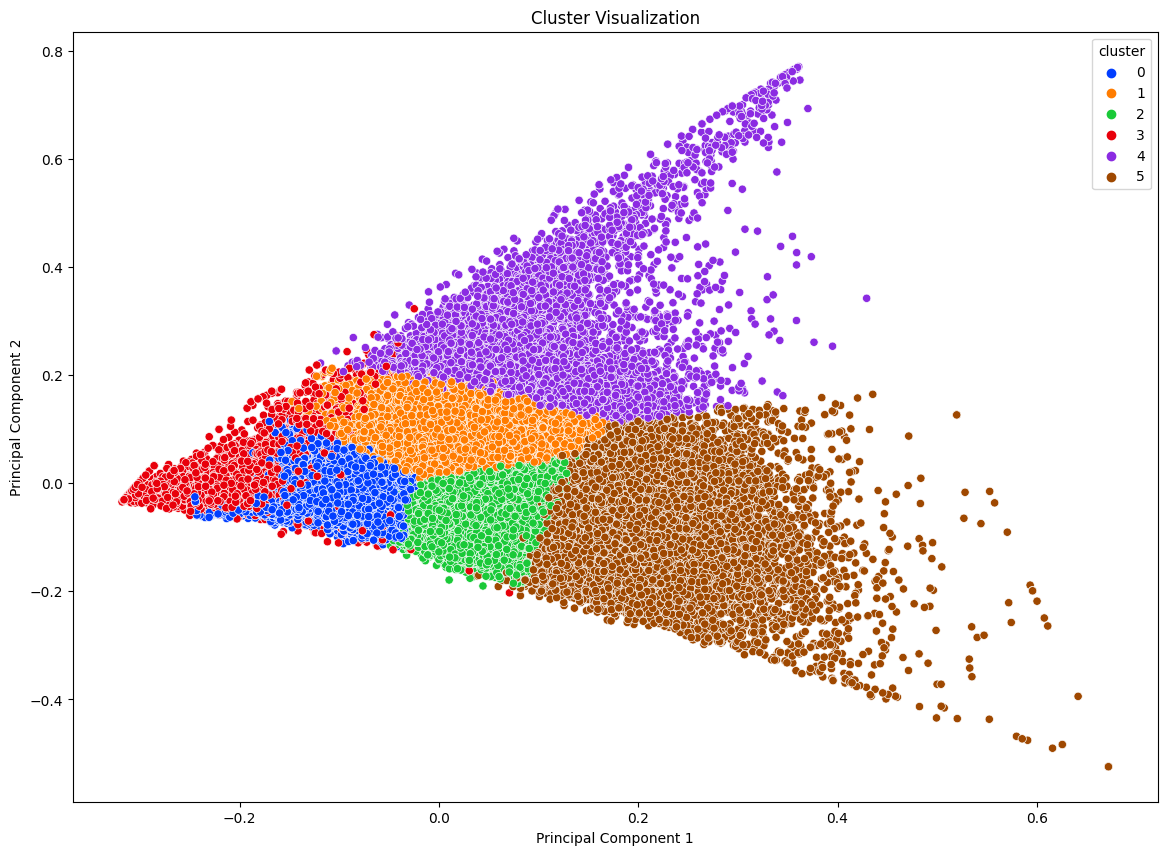

In [ ]:
fig, ax = plt.subplots(figsize = (14, 10))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster", palette = 'bright')
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show()

### Лучшие продукты в кластере

In [ ]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]
cluster6 = cross_df[cross_df.cluster == 5]

In [ ]:
cluster1.shape

(69406, 135)

In [ ]:
cluster1.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
yogurt                           445994
fresh fruits                     418122
chips pretzels                   298425
packaged vegetables fruits       288741
packaged cheese                  286403
fresh vegetables                 264553
water seltzer sparkling water    263155
milk                             260262
ice cream ice                    208432
soft drinks                      207250
dtype: int64

In [ ]:
cluster2.shape

(41908, 135)

In [ ]:
cluster2.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     1247037
fresh vegetables                  500405
packaged vegetables fruits        464950
yogurt                            419016
milk                              249632
packaged cheese                   227707
water seltzer sparkling water     164967
chips pretzels                    157944
soy lactosefree                   157199
bread                             144071
dtype: int64

In [ ]:
cluster3.shape

(52791, 135)

In [ ]:
cluster3.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 1455261
fresh fruits                     1047416
packaged vegetables fruits        633380
yogurt                            426568
packaged cheese                   349453
milk                              263492
soy lactosefree                   216724
water seltzer sparkling water     203181
chips pretzels                    201641
bread                             196180
dtype: int64

In [ ]:
cluster4.shape

(7012, 135)

In [ ]:
cluster4.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    126939
fresh fruits                      22149
soft drinks                       19792
chips pretzels                     9872
energy granola bars                9713
packaged produce                   9451
yogurt                             9242
packaged vegetables fruits         8968
tea                                7897
milk                               7818
dtype: int64

In [ ]:
cluster5.shape

(7979, 135)

In [ ]:
cluster5.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     266398
packaged produce                  57714
packaged vegetables fruits        51234
fresh vegetables                  40127
yogurt                            26503
milk                              23186
water seltzer sparkling water     15918
soy lactosefree                   13724
packaged cheese                   11799
frozen produce                    10767
dtype: int64

In [ ]:
cluster6.shape

(27113, 135)

In [ ]:
cluster6.drop('cluster',axis=1).sum().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 1150365
fresh fruits                      641066
packaged vegetables fruits        318040
yogurt                            125020
fresh herbs                       122802
packaged cheese                    98579
soy lactosefree                    87939
milk                               86625
frozen produce                     78345
water seltzer sparkling water      67373
dtype: int64